# Benchmarking Qmachines with different RB protocols

In [1]:
from RB_stabilizer_verification import machine_response_stabilizer_bench
from RB_standard_verification import machine_response_standard_bench
from RB_with_Rigetti_native_gates import machine_response_srb_native_gate
from RB_with_Rigetti_native_gates_conditional_probability import machine_response_rb_native_gate_conditional
from RB_standard_verification_with_arbitrary_random_unitaries import machine_response_standard_bench_random_units

from functions import averageOfFidelity, stdOfFidelity, decay_param, decay_func
from pyquil import get_qc
from pyquil import noise

In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
import seaborn as sns

In [3]:
from scipy.optimize import curve_fit

In [13]:
k_m = 200 #number of sequences
n_m = 100 #number of shots
n_qubit = 2

qmachine = get_qc( str(2) + "q-qvm" )
# qmachine = get_qc("9q-square-noisy-qvm")
# qmachine = get_qc("9q-square-noisy-qvm")
# qmachine = get_qc( str(n_qubit) + 'q-qvm')  # You can make any 'nq-qvm'
# qmachine = get_qc('Aspen-11',execution_timeout=60, compiler_timeout=100)

### Depolarising noise in terms of pauli channels
$$ \Lambda_{dep}(\rho) = (1-3\lambda/4)\rho + \lambda/4 X^{\dagger}\rho X + \lambda/4 Y^{\dagger}\rho Y + \lambda/4 Z^{\dagger}\rho Z $$

$$ \Lambda_{dep}(\rho) = (1-\epsilon)\rho + \frac{\epsilon}{d} I $$

So if we want to have a depolarising noise channel with $\epsilon = 0.0001$, we should define it with taking into account that $p_i = \frac{\epsilon}{4} $. So it gives

$p_i \approx 0.000025 $

In [14]:
epsilon = 0.01
p_xi = epsilon/4
qmachine.qam.gate_noise=(p_xi,p_xi,p_xi)

In [15]:
noise_model = 'depolarising_noise'
path = os.path.join( os.getcwd(), 'output_storage', noise_model, 'epsilon{}'.format(epsilon) )
try:
    os.makedirs( path )
except:
    pass

In [16]:
ordered_layers = np.arange(5,51,5).astype('int')
max_layer_num = ordered_layers[-1]

ordered_layers_arr = np.array( ordered_layers )
between_layers = np.arange(ordered_layers_arr.min(),ordered_layers_arr.max(),1).astype('int')

np.save( os.path.join(path, 'layers_indices.npy'), ordered_layers_arr )

bench_protocol_func_dict = {'standard':machine_response_standard_bench,
                            'native':machine_response_srb_native_gate,
                            'native_conditional':machine_response_rb_native_gate_conditional,
                            'stabilizer':machine_response_stabilizer_bench,
                            'random_def_unitaries':machine_response_standard_bench_random_units}

In [8]:
sns.set_theme(context='paper', font= 'Serif', style = 'ticks')

In [9]:
def bench_machine(protocol_name:str, qmachine, n_qubit:int, k_m:int, n_m:int):
    avg_fdlty_list = []
    err_fdlty_list = []
    bench_protocol_func = bench_protocol_func_dict[protocol_name]
    for m in tqdm(ordered_layers):
        response = bench_protocol_func(qmachine, n_qubit, m, k_m, n_m)
        avg_fdlty_list.append( averageOfFidelity(response) )
        err_fdlty_list.append( stdOfFidelity(response) )

    np.save( os.path.join(path,'rb_'+ protocol_name + '_{}_avg_layers.npy'.format(max_layer_num)) ,np.array(avg_fdlty_list))    
    np.save( os.path.join(path,'rb_'+ protocol_name +'_{}_err_layers.npy'.format(max_layer_num)) ,np.array(err_fdlty_list))
    return np.array(avg_fdlty_list), np.array(err_fdlty_list)

In [10]:
def extrapolate_decay_func(avg_fdlty_arr, err_fdlty_arr):
    try:
        popt, pcov = curve_fit(decay_func, ordered_layers_arr, avg_fdlty_arr)
    except:
        popt, pcov = curve_fit(decay_func, ordered_layers_arr, avg_fdlty_arr, bounds=([0,0,-10], [1., 10., 0.]))
    return popt, pcov

In [11]:
def plot_decay(avg_fdlty_arr, popt, pcov, title:str):
    fig = plt.figure()
    ax = fig.add_subplot()

    ax.scatter(ordered_layers, avg_fdlty_arr)
    ax.plot(between_layers, decay_func(between_layers, *popt), label = r'${1}*{0}^m+{2}$'.format(*np.round(popt,2)))


    plt.xlabel('Depth', fontsize=18)
    plt.ylabel('Average of Fidelity', fontsize=16)
    plt.title('RB' + title)

    plt.legend()
    fig.savefig('RB_' + title + '.png')

## RB standard version (with Clifford set)

In [19]:
avg_std_fdlty_arr, err_std_fdlty_arr = bench_machine('standard', qmachine, n_qubit, k_m, n_m)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:44<00:00, 22.45s/it]


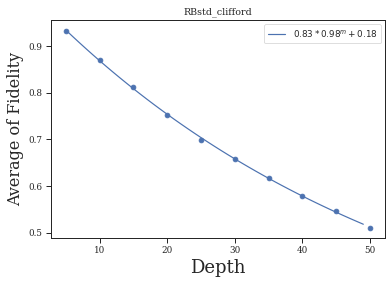

In [20]:
popt_std, pcov_std = extrapolate_decay_func(avg_std_fdlty_arr, err_std_fdlty_arr)
plot_decay(avg_std_fdlty_arr, popt_std, pcov_std, 'std_clifford')

## RB stabilizer version (with Clifford set)

In [21]:
avg_stab_fdlty_arr, err_stab_fdlty_arr = bench_machine('stabilizer', qmachine, n_qubit, k_m, n_m)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [11:18<00:00, 67.83s/it]


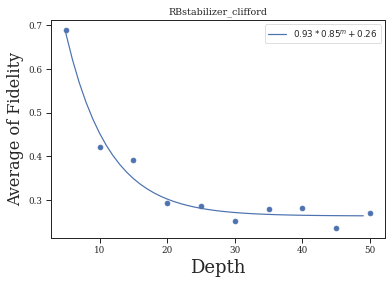

In [22]:
popt_stab, pcov_stab = extrapolate_decay_func(avg_stab_fdlty_arr, err_stab_fdlty_arr)
plot_decay(avg_stab_fdlty_arr, popt_stab, pcov_stab, 'stabilizer_clifford')

## RB standard version (with Riggetti native gate set)

In [24]:
avg_native_fdlty_arr, err_native_fdlty_arr = bench_machine('native', qmachine, n_qubit, k_m, n_m)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:00<00:00, 30.02s/it]


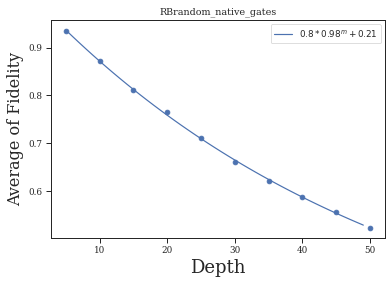

In [25]:
popt_native, pcov_native = extrapolate_decay_func(avg_native_fdlty_arr, err_native_fdlty_arr)
plot_decay(avg_native_fdlty_arr, popt_native, pcov_native, 'random_native_gates')

## RB standard version (with arbitary random unitary set)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [11:50<00:00, 71.06s/it]


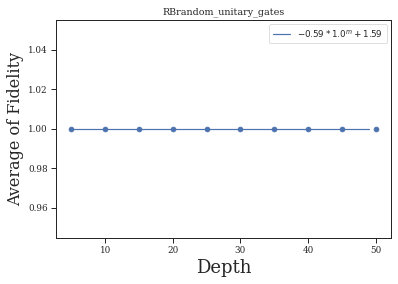

In [24]:
avg_runitary_fdlty_arr, err_runitary_fdlty_arr = bench_machine('random_def_unitaries', qmachine, n_qubit, k_m, n_m)
popt_runitary, pcov_runitary = extrapolate_decay_func(avg_runitary_fdlty_arr, err_runitary_fdlty_arr)
plot_decay(avg_runitary_fdlty_arr, popt_runitary, pcov_runitary, 'random_unitary_gates')

# RB with conditional prob. on native gates

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [15:53<00:00, 95.35s/it]


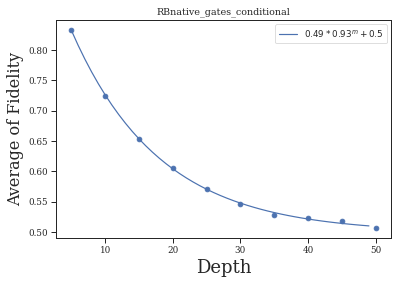

In [22]:
avg_cond_fdlty_arr, err_cond_fdlty_arr = bench_machine('native_conditional', qmachine, n_qubit, k_m, n_m)
popt_cond, pcov_cond = extrapolate_decay_func(avg_cond_fdlty_arr, err_cond_fdlty_arr)
plot_decay(avg_cond_fdlty_arr, popt_cond, pcov_cond, 'native_gates_conditional')

## Diamond distance

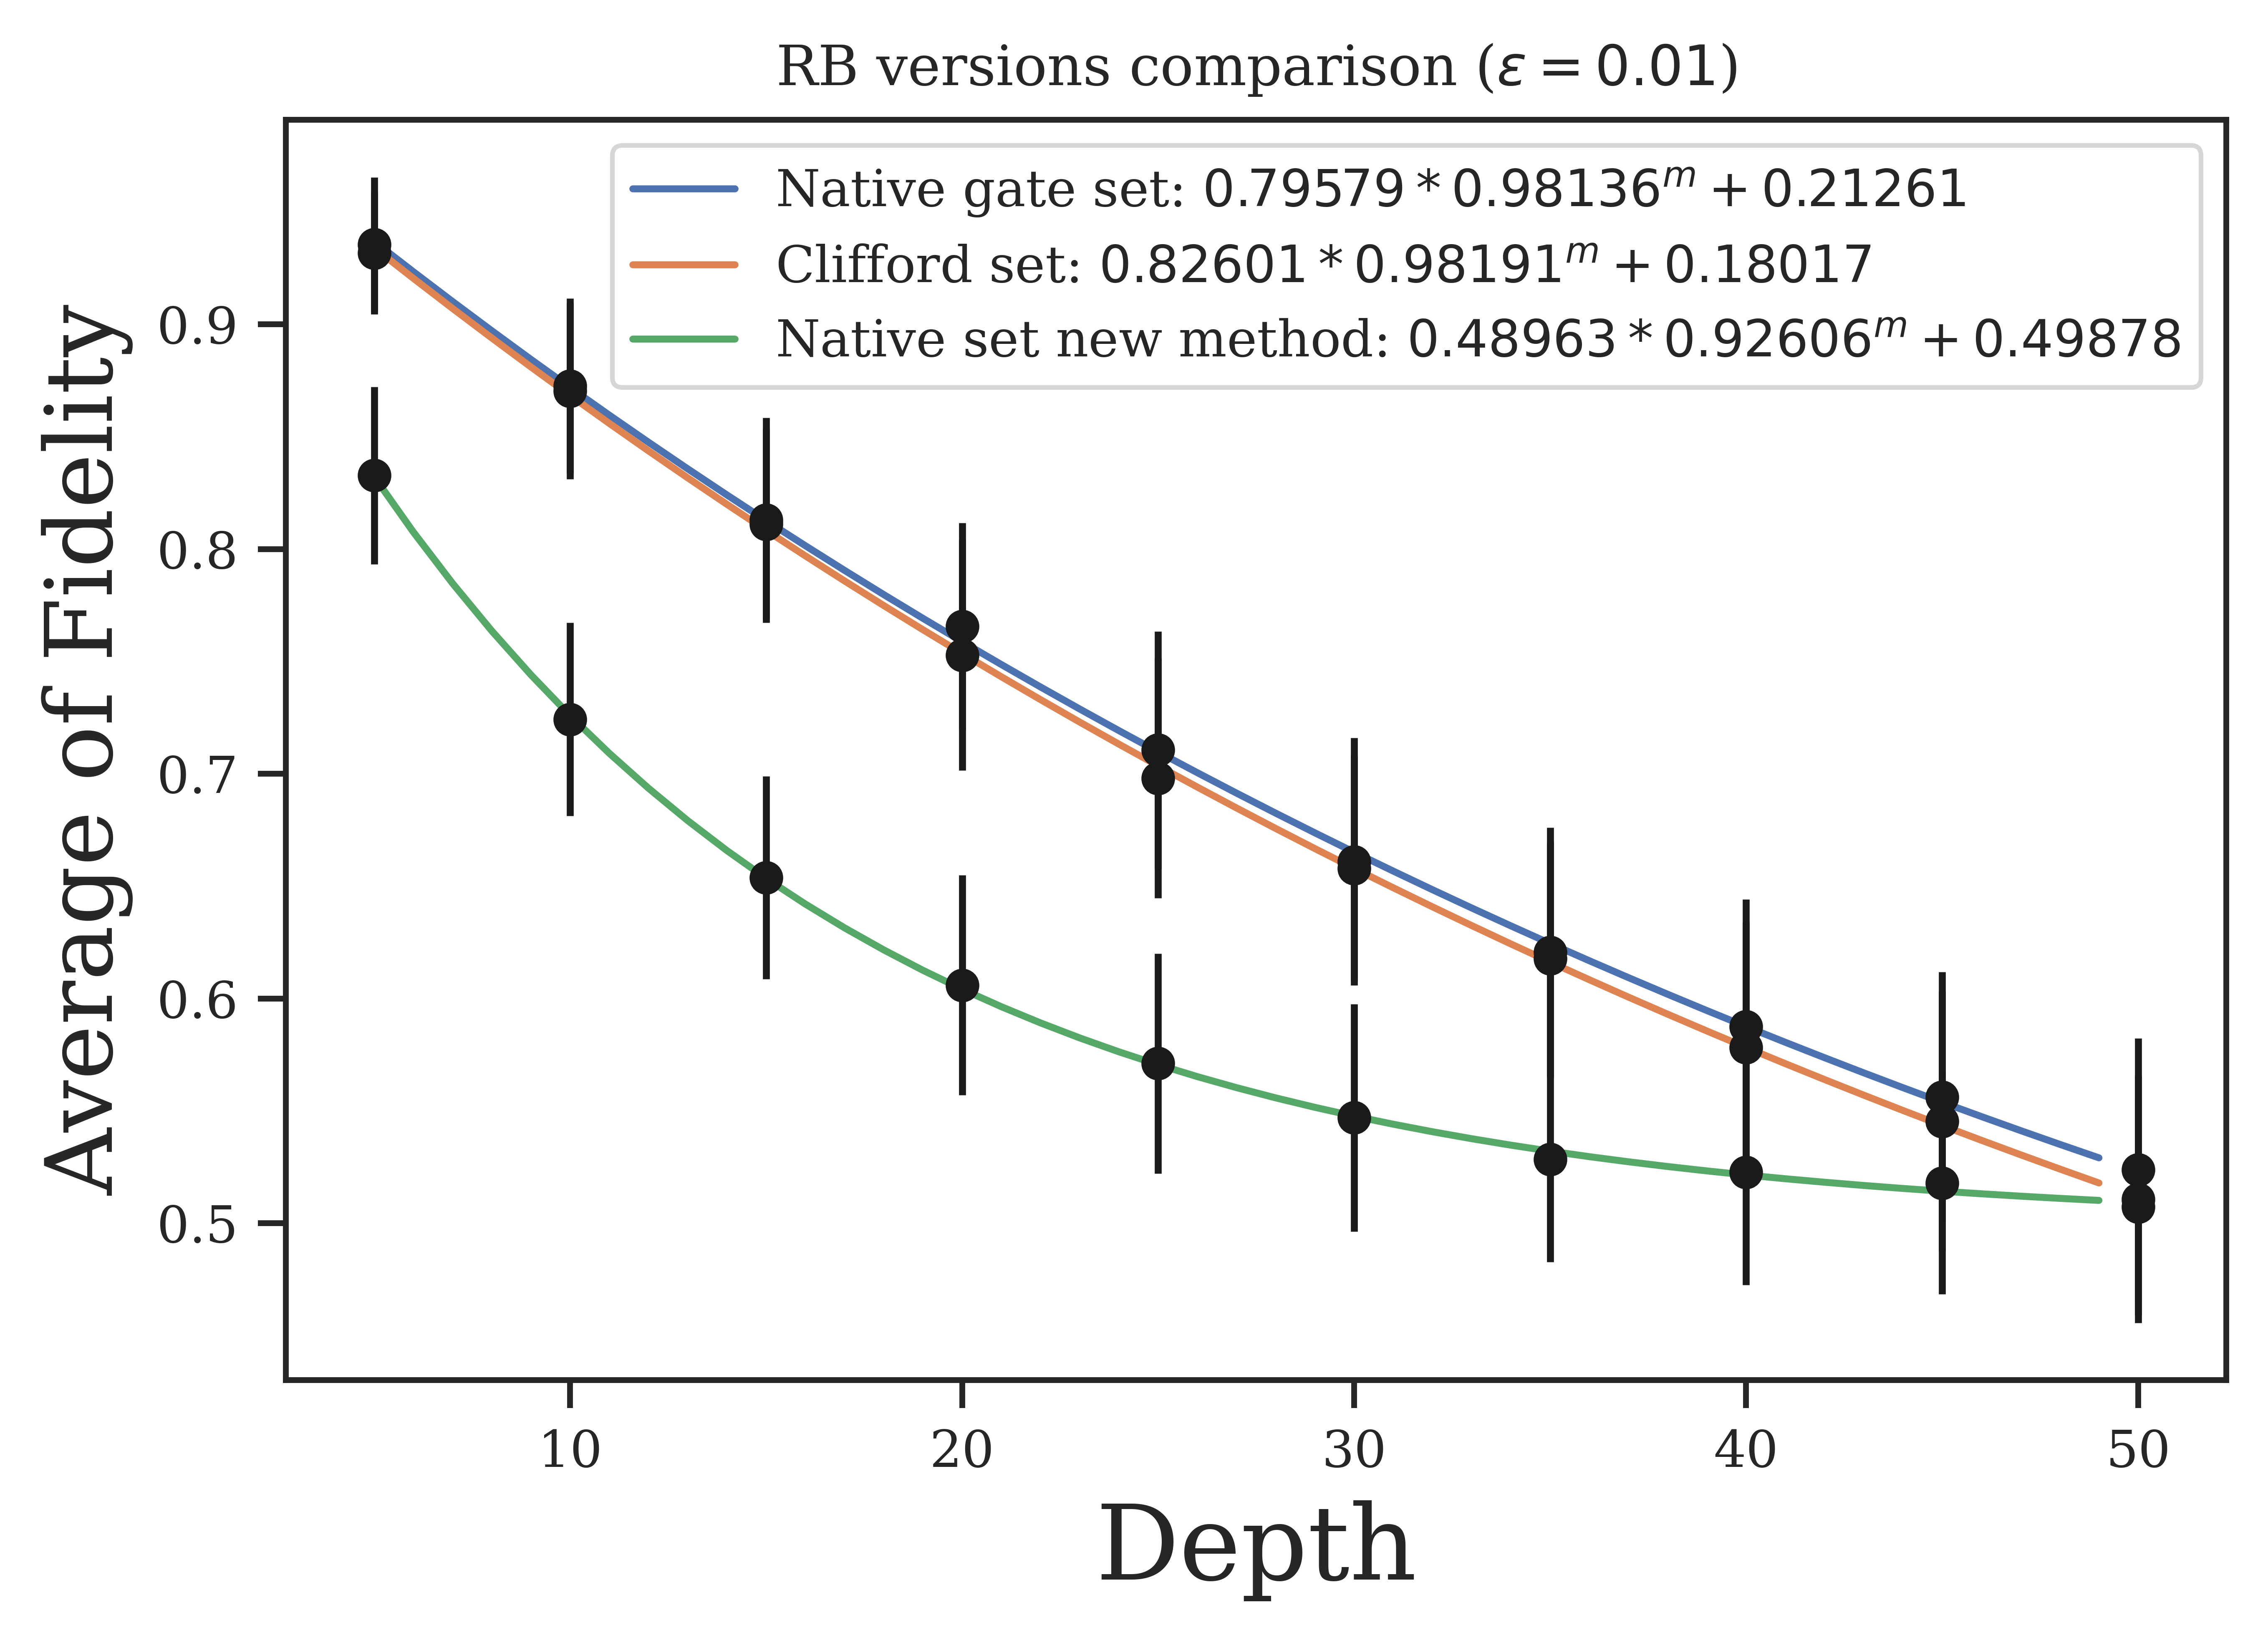

In [26]:
fig = plt.figure(dpi = 1000)
ax = fig.add_subplot()

# plt.loglog()

ax.errorbar(ordered_layers, avg_native_fdlty_arr, yerr = err_native_fdlty_arr, fmt='o',color = 'k')
ax.errorbar(ordered_layers, avg_std_fdlty_arr, yerr = err_std_fdlty_arr, fmt = 'o', color = 'k')
ax.errorbar(ordered_layers, avg_cond_fdlty_arr, yerr = err_cond_fdlty_arr, fmt='o',color = 'k')

ax.plot(between_layers, decay_func(between_layers, *popt_native),
        label = r'Native gate set: ${1}*{0}^m+{2}$'.format(*np.round(popt_native,5)))
ax.plot(between_layers, decay_func(between_layers, *popt_std),
        label = r'Clifford set: ${1}*{0}^m+{2}$'.format(*np.round(popt_std,5)))
ax.plot(between_layers, decay_func(between_layers, *popt_cond),
        label = r'Native set new method: ${1}*{0}^m+{2}$'.format(*np.round(popt_cond,5)))

plt.xlabel('Depth', fontsize=18)
plt.ylabel('Average of Fidelity', fontsize=16)
plt.title(r'RB versions comparison ($\epsilon = {}$)'.format(epsilon))

plt.legend()

fig.savefig('RB_comparison.png')

r parameter for Native gateset

In [28]:
decay_param(popt_native[0], n_qubit)

0.013982062831565806

r parameter for Clifford gateset

In [29]:
decay_param(popt_std[0], n_qubit)

0.01356545010277524

r parameter for Native benchmarking new method!

In [30]:
decay_param(popt_cond[0], n_qubit)

0.055458544558714545